###### Все необходимые установки

ДЗ. Решить задачу просрочки кредита используя для прогнозирования нейронные сети.

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sqlite3

import catboost as cat
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_score, \
              recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, \
              auc, mean_squared_error, accuracy_score
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn import preprocessing

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Загрузка данных из файла
data = pd.read_csv("MFOcredit.csv", encoding='cp1251', sep=';')
data.head(5).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5 non-null      int64 
 1   date_start    5 non-null      object
 2   date_end      5 non-null      object
 3   gender        5 non-null      object
 4   age           5 non-null      int64 
 5   auto          5 non-null      object
 6   housing       5 non-null      object
 7   marstatus     5 non-null      object
 8   regclient     5 non-null      object
 9   jobtype       5 non-null      object
 10  region        5 non-null      object
 11  credits       5 non-null      object
 12  children      5 non-null      object
 13  delinq60plus  5 non-null      object
dtypes: int64(2), object(12)
memory usage: 688.0+ bytes


In [4]:
# Замена пропусков на NaN
data.replace('Пропуск поля', np.nan, inplace=True)  

In [62]:
# Подсчет количества категорий
category_counts_auto = data['auto'].value_counts()
category_counts_auto

Нет    17465
Да      3670
Name: auto, dtype: int64

In [100]:
nan_count_method_1 = data.isna().sum()
nan_count_method_1

id                  0
date_start          0
date_end            0
gender              0
age                 0
auto            14077
housing          7603
marstatus        7564
regclient           0
jobtype         14457
region              0
credits           946
children          745
delinq60plus        0
dtype: int64

In [7]:
# Выделение признаков и целевой переменной
X = data.drop(columns=['delinq60plus'])  
y = data['delinq60plus'] 

In [8]:
# Замена значений в целевой переменной
y = y.replace({'Да': 1, 'Нет': 0})

In [13]:
# Преобразование строковых столбцов в объекты даты
X['date_start'] = pd.to_datetime(X['date_start'])
X['date_end'] = pd.to_datetime(X['date_end'])

# Вычисление разницы в днях и сохранение в новом столбце
X['date_difference_days'] = (X['date_end'] - X['date_start']).dt.days

In [16]:
# Удаление столбцов
columns_to_drop = ['date_start', 'date_end']
X.drop(columns=columns_to_drop, inplace=True)

In [18]:
# Разделение столбцов на категориальные и числовые
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=['number']).columns

In [19]:
categorical_columns

Index(['gender', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype',
       'region', 'credits', 'children'],
      dtype='object')

In [20]:
X

,id,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,date_difference_days
0,1,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,9
1,2,Мужской,21,NaN,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,14
2,3,Мужской,25,NaN,Собственное,Холост,Да,Официальное,Кемеровская область север,NaN,Нет,14
3,4,Женский,47,NaN,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,14
4,5,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,14
...,...,...,...,...,...,...,...,...,...,...,...,...
35207,35208,Мужской,30,Да,Долевая собственность,Гражданский брак/женат/замужем,Да,Официальное,Алтайский край,Да,Да,14
35208,35209,Женский,57,Нет,Собственное,Разведен,Да,NaN,Алтайский край,Да,Нет,14
35209,35210,Женский,38,NaN,NaN,NaN,Да,NaN,Новосибирская область,Нет,Да,14
35210,35211,Женский,19,NaN,NaN,NaN,Да,NaN,Кемеровская область юг,Нет,Нет,14


In [21]:
# Однократное кодирование строковых категориальных признаков
X = pd.get_dummies(X, columns=['gender', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype',
       'region', 'credits', 'children'])  

In [48]:
# Разделение данных на обучающую (70%), валидационную (15%) и тестовую (15%) выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Вывод размеров выборок
print("Обучающая выборка:", X_train.shape, y_train.shape)
print("Валидационная выборка:", X_val.shape, y_val.shape)
print("Тестовая выборка:", X_test.shape, y_test.shape)

Обучающая выборка: (24648, 29) (24648,)
Валидационная выборка: (5282, 29) (5282,)
Тестовая выборка: (5282, 29) (5282,)


In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 29 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   id                                        35212 non-null  int64
 1   age                                       35212 non-null  int64
 2   date_difference_days                      35212 non-null  int64
 3   gender_Женский                            35212 non-null  uint8
 4   gender_Мужской                            35212 non-null  uint8
 5   auto_Да                                   35212 non-null  uint8
 6   auto_Нет                                  35212 non-null  uint8
 7   housing_Арендуемое                        35212 non-null  uint8
 8   housing_Долевая собственность             35212 non-null  uint8
 9   housing_Живут с родителями                35212 non-null  uint8
 10  housing_Муниципальное                     35212 non-null  

In [50]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 35212 entries, 0 to 35211
Series name: delinq60plus
Non-Null Count  Dtype
--------------  -----
35212 non-null  int64
dtypes: int64(1)
memory usage: 275.2 KB


In [54]:
# Масштабирование признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [55]:
X_train

array([[ 0.65927898,  0.51350508, -0.08108958, ...,  0.96821032,
        -0.77822124,  0.8131742 ],
       [ 0.16444305,  1.12085157, -0.08108958, ...,  0.96821032,
         1.28498163, -1.22974881],
       [-0.08331999, -0.77710622, -0.787992  , ...,  0.96821032,
        -0.77822124,  0.8131742 ],
       ...,
       [-0.62193101,  0.81717833, -1.49489443, ..., -1.03283345,
        -0.77822124,  0.8131742 ],
       [-1.6496596 , -0.09384142, -0.08108958, ...,  0.96821032,
        -0.77822124,  0.8131742 ],
       [-0.17718009, -0.47343297, -0.08108958, ..., -1.03283345,
         1.28498163, -1.22974881]])

In [86]:
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
keras.backend.clear_session()

In [87]:
X_train.shape[1:]

(29,)

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

In [97]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[29]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [98]:
model.save("my_keras_model.h5")

In [99]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
771/771 [==============================] - 1s 1ms/step - loss: 0.2872 - val_loss: 0.2431
Epoch 2/100
771/771 [==============================] - 1s 942us/step - loss: 0.2328 - val_loss: 0.2207
Epoch 3/100
771/771 [==============================] - 1s 884us/step - loss: 0.2160 - val_loss: 0.2096
Epoch 4/100
771/771 [==============================] - 1s 879us/step - loss: 0.2062 - val_loss: 0.2020
Epoch 5/100
771/771 [==============================] - 1s 910us/step - loss: 0.1996 - val_loss: 0.1963
Epoch 6/100
771/771 [==============================] - 1s 898us/step - loss: 0.1946 - val_loss: 0.1922
Epoch 7/100
771/771 [==============================] - 1s 905us/step - loss: 0.1907 - val_loss: 0.1890
Epoch 8/100
771/771 [==============================] - 1s 933us/step - loss: 0.1876 - val_loss: 0.1867
Epoch 9/100
771/771 [==============================] - 1s 897us/step - loss: 0.1851 - val_loss: 0.1844
Epoch 10/100
771/771 [==============================] - 1s 959us/step - los

In [101]:
from datetime import datetime
counter = 0

In [102]:
from tensorflow.keras.callbacks import TensorBoard
file_name = 'my_saved_model'  #!! ВНИМАНИЕ !! TensorBoard НЕ обновляет журнал лога а добавляет в журнал лога новую информацию. Если менять модель и запускать его несколько раз то будет КАША!
# !! Новая модель - НОВЫЙ файл !!

logs = "logs\\{}".format(file_name) +"_"+ datetime.now().strftime("%Y%m%d-%H%M%S")+"__"+str(counter)
tensorboard = TensorBoard(log_dir=logs, histogram_freq = 1,
                                                 profile_batch = '100,120')
#tf.debugging.experimental.enable_dump_debug_info("logs\\{}".format(file_name), tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)
counter +=1

In [103]:
import tensorflow as tf
tf.keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True,show_dtype=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [104]:
pred = model.predict(X_test, batch_size=32, verbose=0)

In [105]:
np.argmax(pred[0])

0

In [106]:
from sklearn.metrics import confusion_matrix

In [107]:
pred_rev = np.argmax(pred, axis=1)

In [108]:
confusion_matrix(y_test, pred_rev)

array([[3242,    0],
       [2040,    0]], dtype=int64)

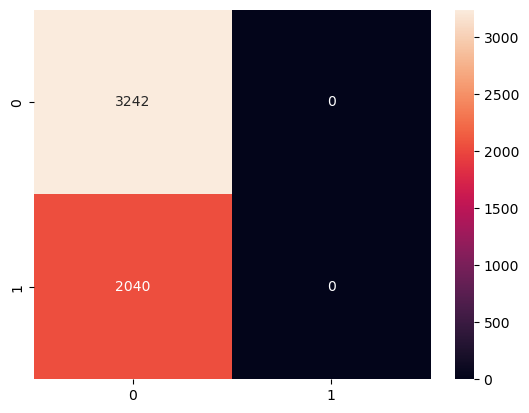

In [109]:
import seaborn as sns
cm = confusion_matrix(y_test, pred_rev)

sns.heatmap(cm, annot=True , fmt=".0f");

In [110]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_rev)

0.6137826580840591

# Тонкая настройка гиперпараметров нейронной сети

In [118]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[29]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [119]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\user\AppData\Local\Temp\ipykernel_3808\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [120]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
771/771 [==============================] - 1s 972us/step - loss: 0.2671 - val_loss: 0.1927
Epoch 2/100
771/771 [==============================] - 1s 842us/step - loss: 0.1903 - val_loss: 0.1777
Epoch 3/100
771/771 [==============================] - 1s 841us/step - loss: 0.1802 - val_loss: 0.1724
Epoch 4/100
771/771 [==============================] - 1s 871us/step - loss: 0.1751 - val_loss: 0.1682
Epoch 5/100
771/771 [==============================] - 1s 867us/step - loss: 0.1719 - val_loss: 0.1660
Epoch 6/100
771/771 [==============================] - 1s 887us/step - loss: 0.1698 - val_loss: 0.1643
Epoch 7/100
771/771 [==============================] - 1s 894us/step - loss: 0.1683 - val_loss: 0.1635
Epoch 8/100
771/771 [==============================] - 1s 870us/step - loss: 0.1672 - val_loss: 0.1631
Epoch 9/100
771/771 [==============================] - 1s 840us/step - loss: 0.1663 - val_loss: 0.1621
Epoch 10/100
771/771 [==============================] - 1s 844us/step - l

In [121]:
mse_test = keras_reg.score(X_test, y_test)

166/166 [==============================] - 0s 692us/step - loss: 0.1612


In [122]:
y_pred = keras_reg.predict(X_test)

166/166 [==============================] - 0s 655us/step


In [125]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=2, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=30,
                  validation_data=(X_val, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/30


c:\Users\user\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


514/514 [==============================] - 1s 1ms/step - loss: 0.2114 - val_loss: 0.1852
Epoch 2/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1814 - val_loss: 0.1754
Epoch 3/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1733 - val_loss: 0.1698
Epoch 4/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1687 - val_loss: 0.1660
Epoch 5/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1656 - val_loss: 0.1639
Epoch 6/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1633 - val_loss: 0.1623
Epoch 7/30
514/514 [==============================] - 1s 994us/step - loss: 0.1614 - val_loss: 0.1612
Epoch 8/30
514/514 [==============================] - 1s 996us/step - loss: 0.1599 - val_loss: 0.1602
Epoch 9/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1587 - val_loss: 0.1600
Epoch 10/30
514/514 [==============================] - 1s 999us/step - loss: 0.1577 - val_loss: 0.1588
Epoc

c:\Users\user\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


514/514 [==============================] - 1s 1ms/step - loss: 0.2276 - val_loss: 0.1817
Epoch 2/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1797 - val_loss: 0.1715
Epoch 3/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1725 - val_loss: 0.1672
Epoch 4/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1686 - val_loss: 0.1649
Epoch 5/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1660 - val_loss: 0.1629
Epoch 6/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1639 - val_loss: 0.1617
Epoch 7/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1625 - val_loss: 0.1607
Epoch 8/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1613 - val_loss: 0.1602
Epoch 9/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1602 - val_loss: 0.1597
Epoch 10/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1591 - val_loss: 0.1607
Epoch 11/3

c:\Users\user\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


514/514 [==============================] - 1s 1ms/step - loss: 0.2277 - val_loss: 0.1871
Epoch 2/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1862 - val_loss: 0.1754
Epoch 3/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1767 - val_loss: 0.1699
Epoch 4/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1718 - val_loss: 0.1671
Epoch 5/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1687 - val_loss: 0.1648
Epoch 6/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1661 - val_loss: 0.1633
Epoch 7/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1644 - val_loss: 0.1623
Epoch 8/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1630 - val_loss: 0.1611
Epoch 9/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1616 - val_loss: 0.1614
Epoch 10/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1605 - val_loss: 0.1611
Epoch 11/3

c:\Users\user\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


514/514 [==============================] - 1s 1ms/step - loss: 0.1884 - val_loss: 0.1628
Epoch 2/30
514/514 [==============================] - 0s 851us/step - loss: 0.1655 - val_loss: 0.1642
Epoch 3/30
514/514 [==============================] - 0s 898us/step - loss: 0.1647 - val_loss: 0.1606
Epoch 4/30
514/514 [==============================] - 0s 868us/step - loss: 0.1646 - val_loss: 0.1636
Epoch 5/30
514/514 [==============================] - 0s 892us/step - loss: 0.1650 - val_loss: 0.1615
Epoch 6/30
514/514 [==============================] - 0s 885us/step - loss: 0.1650 - val_loss: 0.1588
Epoch 7/30
514/514 [==============================] - 0s 884us/step - loss: 0.1643 - val_loss: 0.1625
Epoch 8/30
514/514 [==============================] - 0s 885us/step - loss: 0.1647 - val_loss: 0.1610
Epoch 9/30
257/257 [==============================] - 0s 646us/step - loss: 0.1657
[CV] END learning_rate=0.027770456976200626, n_hidden=0, n_neurons=3; total time=   4.5s
Epoch 1/30
  1/514 [.....

c:\Users\user\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


514/514 [==============================] - 1s 1ms/step - loss: 0.2129 - val_loss: 0.1634
Epoch 2/30
514/514 [==============================] - 0s 907us/step - loss: 0.1664 - val_loss: 0.1643
Epoch 3/30
514/514 [==============================] - 0s 880us/step - loss: 0.1665 - val_loss: 0.1603
Epoch 4/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1660 - val_loss: 0.1610
Epoch 5/30
514/514 [==============================] - 1s 1ms/step - loss: 0.1659 - val_loss: 0.1622
Epoch 6/30
257/257 [==============================] - 0s 822us/step - loss: 0.1642
[CV] END learning_rate=0.027770456976200626, n_hidden=0, n_neurons=3; total time=   3.6s
Epoch 1/30


c:\Users\user\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


514/514 [==============================] - 1s 1ms/step - loss: 0.1987 - val_loss: 0.1640
Epoch 2/30
514/514 [==============================] - 0s 874us/step - loss: 0.1664 - val_loss: 0.1624
Epoch 3/30
514/514 [==============================] - 0s 864us/step - loss: 0.1657 - val_loss: 0.1619
Epoch 4/30
514/514 [==============================] - 0s 883us/step - loss: 0.1653 - val_loss: 0.1624
Epoch 5/30
514/514 [==============================] - 0s 878us/step - loss: 0.1650 - val_loss: 0.1651
Epoch 6/30
257/257 [==============================] - 0s 675us/step - loss: 0.1652
[CV] END learning_rate=0.027770456976200626, n_hidden=0, n_neurons=3; total time=   3.2s
Epoch 1/30
771/771 [==============================] - 1s 1ms/step - loss: 0.2138 - val_loss: 0.1836
Epoch 2/30
771/771 [==============================] - 1s 976us/step - loss: 0.1792 - val_loss: 0.1720
Epoch 3/30
771/771 [==============================] - 1s 959us/step - loss: 0.1710 - val_loss: 0.1679
Epoch 4/30
771/771 [=======

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002251BFE6EE0>,
                   n_iter=2,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002251C158640>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   verbose=2)

In [126]:
rnd_search_cv.best_params_

{'learning_rate': 0.0051747964719537, 'n_hidden': 3, 'n_neurons': 55}

In [127]:
rnd_search_cv.best_score_

-0.16026932497819266

In [128]:
rnd_search_cv.score(X_test, y_test)

166/166 [==============================] - 0s 697us/step - loss: 0.1591


-0.15907828509807587

In [130]:
model = rnd_search_cv.best_estimator_.model
model

In [131]:
model.evaluate(X_test, y_test)

166/166 [==============================] - 0s 721us/step - loss: 0.1591


0.15907828509807587